# Main Codebase

🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-19. -10. -19. -10.]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [-10. -10. -19. -19.]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [-10. -10. -19. -19.]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-19. -19. -10. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-19. -19. -10. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-19. -19. -10. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'E', 'E'), 0): [-19. -10. -10. -10.]
(('E', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [-10. -10. -19. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-19. -10. -10. -10.]
(('E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-10. -10. -10. -10.]
(('O', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [-10. -10. -19. -10.]


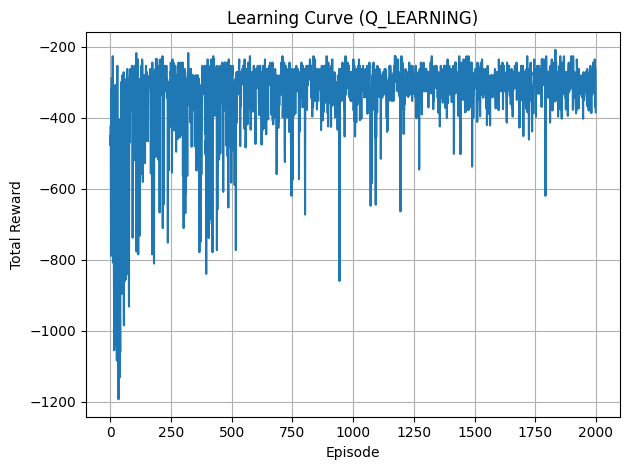

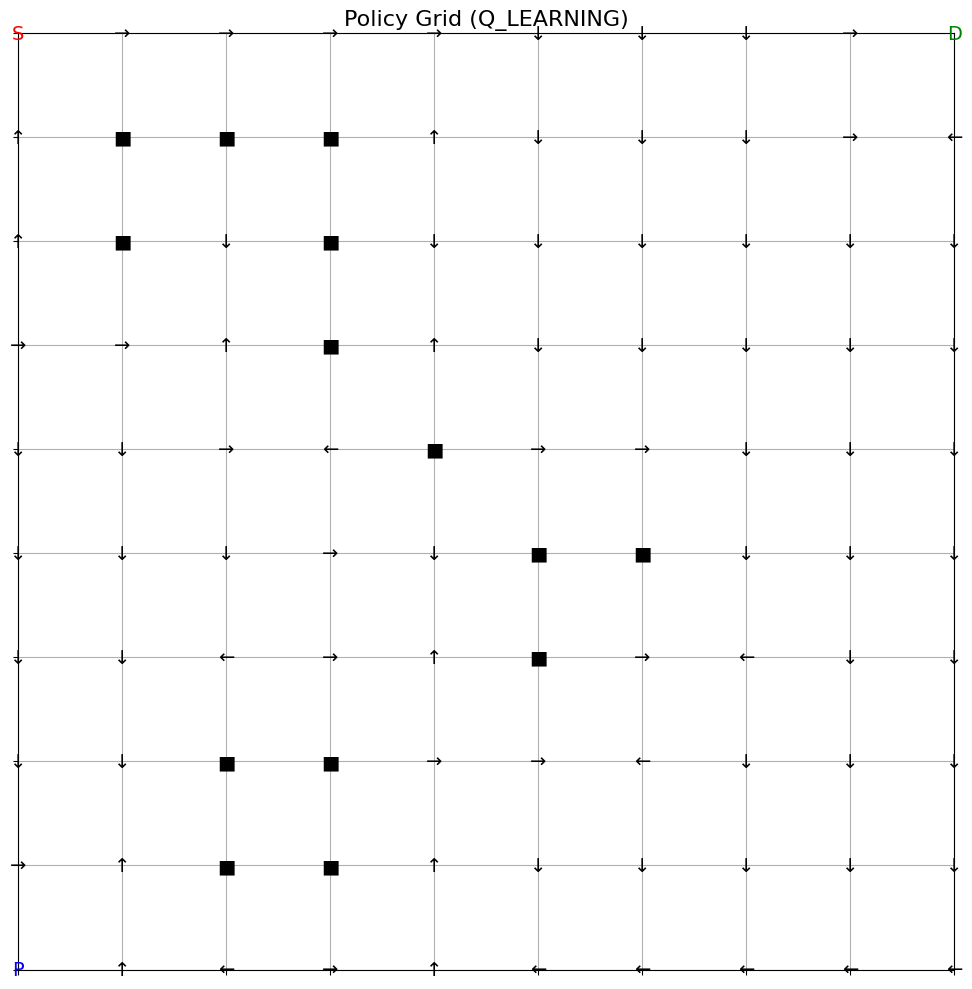

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


# Investigation Tasks

## Parameter Sensitivity

### Learning Rate (0.01, 0.5)

🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-16.6866865   -9.15329112 -16.78676922  -9.15400356]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [ -9.13726878  -9.13642945 -15.88038992 -16.24015411]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-15.78242719 -15.51047193  -9.1399917   -9.13938865]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [ -9.12085594  -9.12045588 -16.16498375 -15.94150585]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-16.45296574 -16.07875717  -9.12489046  -9.12561172]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-15.58038693 -16.02596504  -9.11061681  -9.11067506]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'E', 'E'), 0): [-16.10410293  -9.09544141  -9.09539991  -9.09503954]
(('E', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [ -9.09307144  -9.09294517 -16.31485728  -9.09484579]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-17.60947839  -9.1

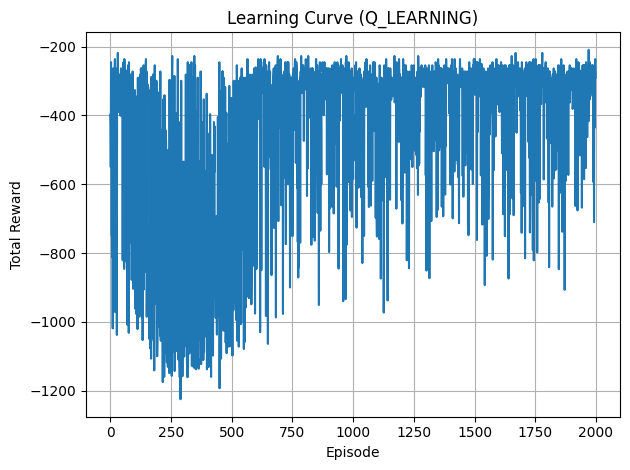

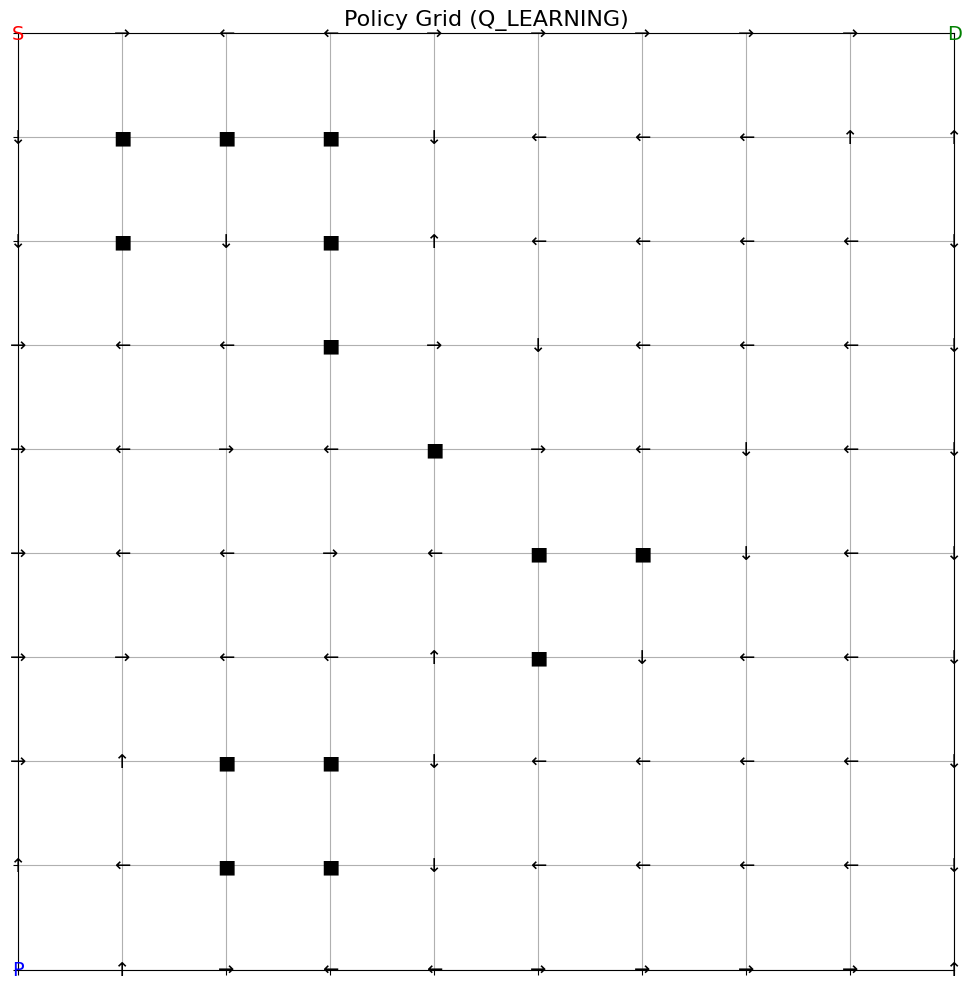

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.01      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-19. -10. -19. -10.]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [-10. -10. -19. -19.]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-19. -19. -10. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-19. -19. -10. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-19. -19. -10. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'E', 'E'), 0): [-19. -10. -10. -10.]
(('E', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [-10. -10. -19. -10.]
(('O', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [-10. -10. -19. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-19. -10. -10. -10.]
(('E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-10. -10. -10. -10.]
(('W', 'W', 'W', 'E', 'E', 'D', 'E', 'E', 'E'), 0): [-19. -10. -10. -10.]


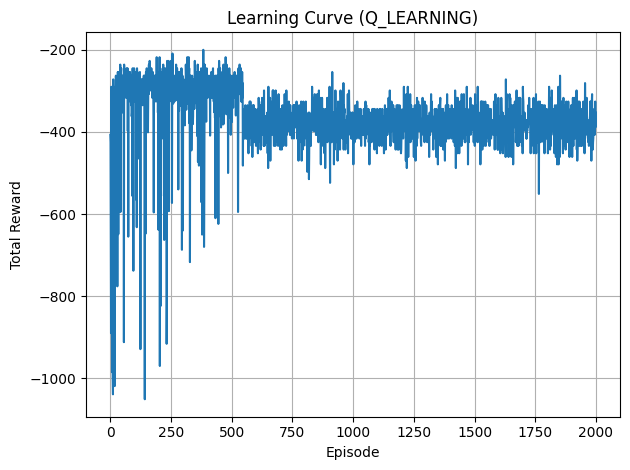

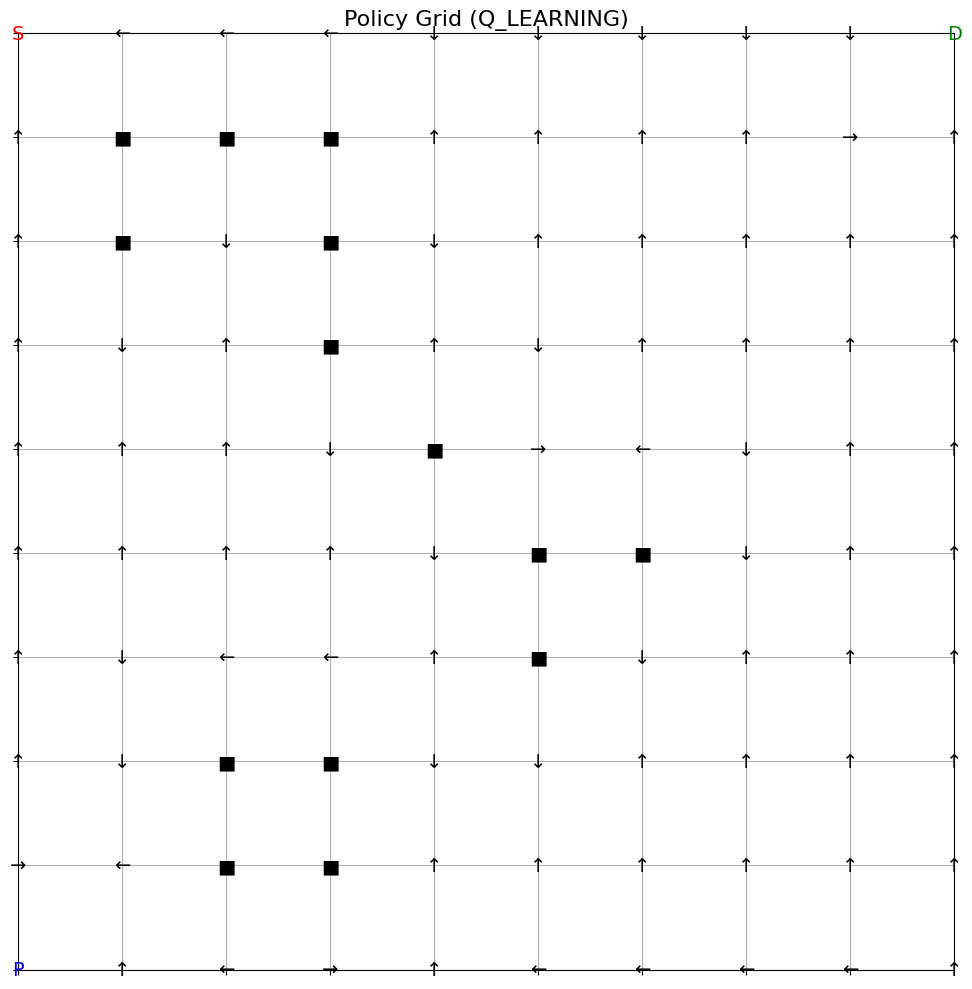

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.5      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


### Discount factor (0.5, 0.99)

🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-10.95501366  -1.90901428 -10.95486523  -1.97744357]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [ -1.95516536  -1.81497012 -10.91106453 -10.9110609 ]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-10.92483792 -10.96094555  -1.9551852   -1.9887764 ]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-10.92231633 -10.91723639  -1.97765426  -1.99450323]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-10.95771964 -10.90565953  -1.98875034  -1.99723274]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [ -1.91038836  -1.62949483 -10.82016655 -10.81856439]
(('W', 'E', 'O', 'W', 'E', 'E', 'W', 'E', 'E'), 0): [ -1.81834159  -1.28716513 -10.64263008  -1.92194541]
(('W', 'E', 'E', 'W', 'E', 'E', 'W', 'E', 'E'), 0): [ -1.47693585  -0.50559383 -10.35095602  -1.69656109]
(('E', 'O', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-10.9242522   -1.9

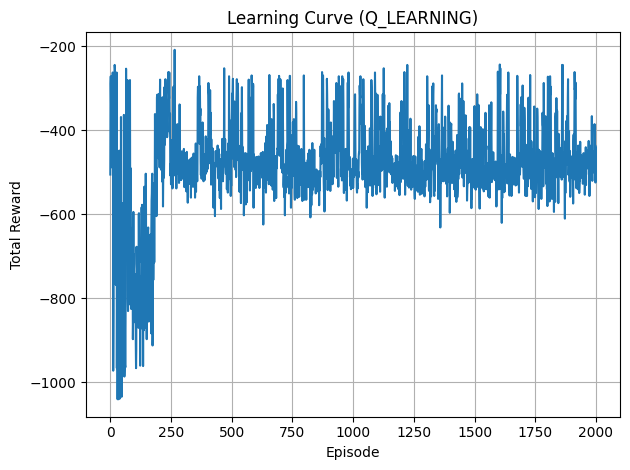

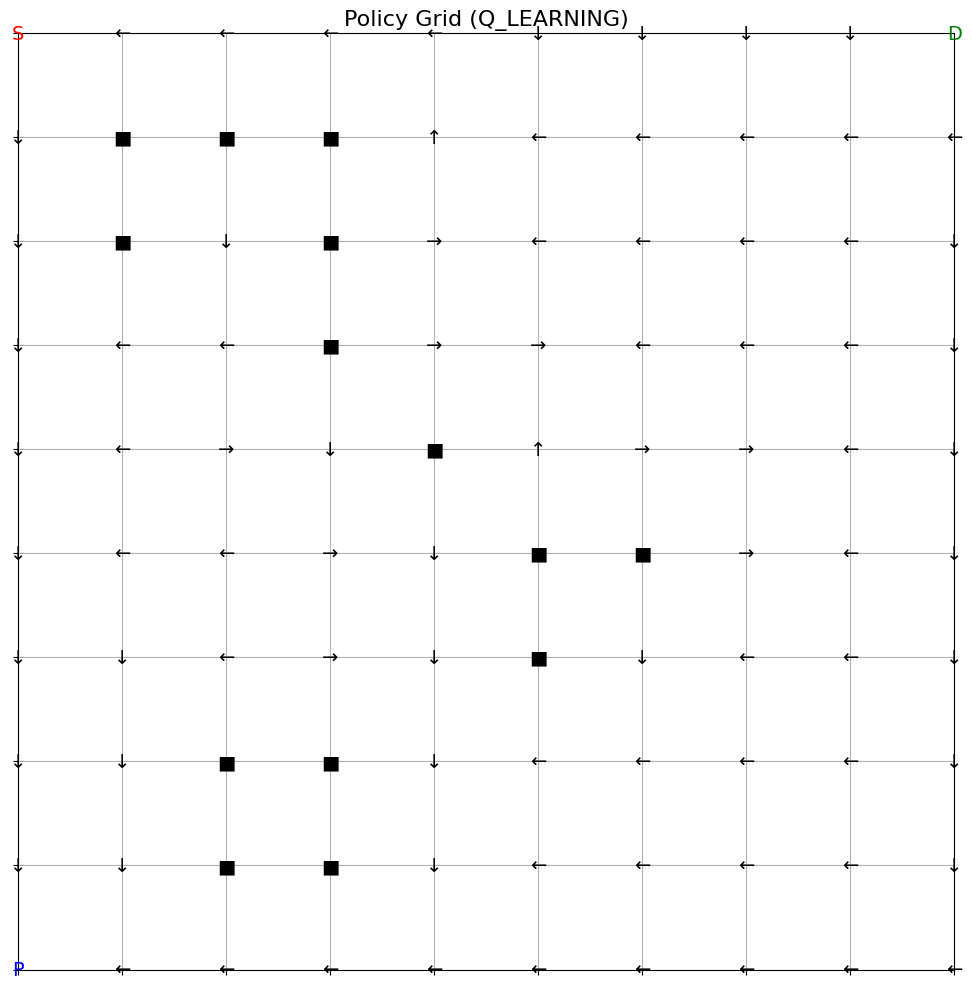

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.5      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-101.81735476  -93.14996845 -101.81413824  -93.15292088]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [ -93.1384609   -93.133681   -101.25713886 -101.57410178]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-101.69786555 -101.50645281  -93.14590011  -93.15045445]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [ -93.12002915  -93.11946614 -101.00583249 -101.5055293 ]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-101.74717214 -101.41854763  -93.14374289  -93.14377522]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-101.61151068 -101.53869372  -93.13703412  -93.14326705]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'E', 'E'), 0): [-101.52728963  -93.14026387  -93.13746258  -93.13913092]
(('E', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [ -93.13958226  -93.14548251 -101.39030274  -93.14096198]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'E

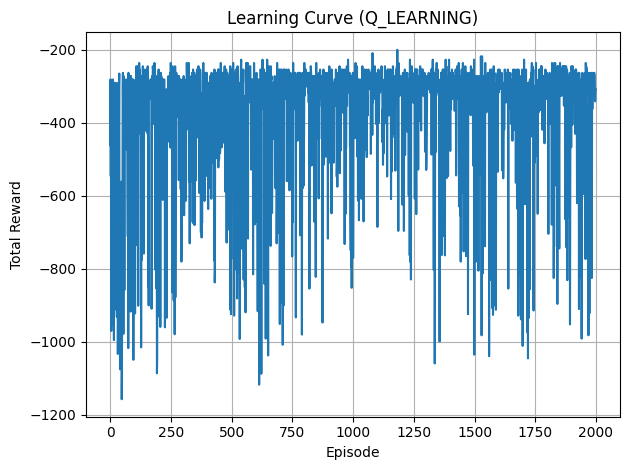

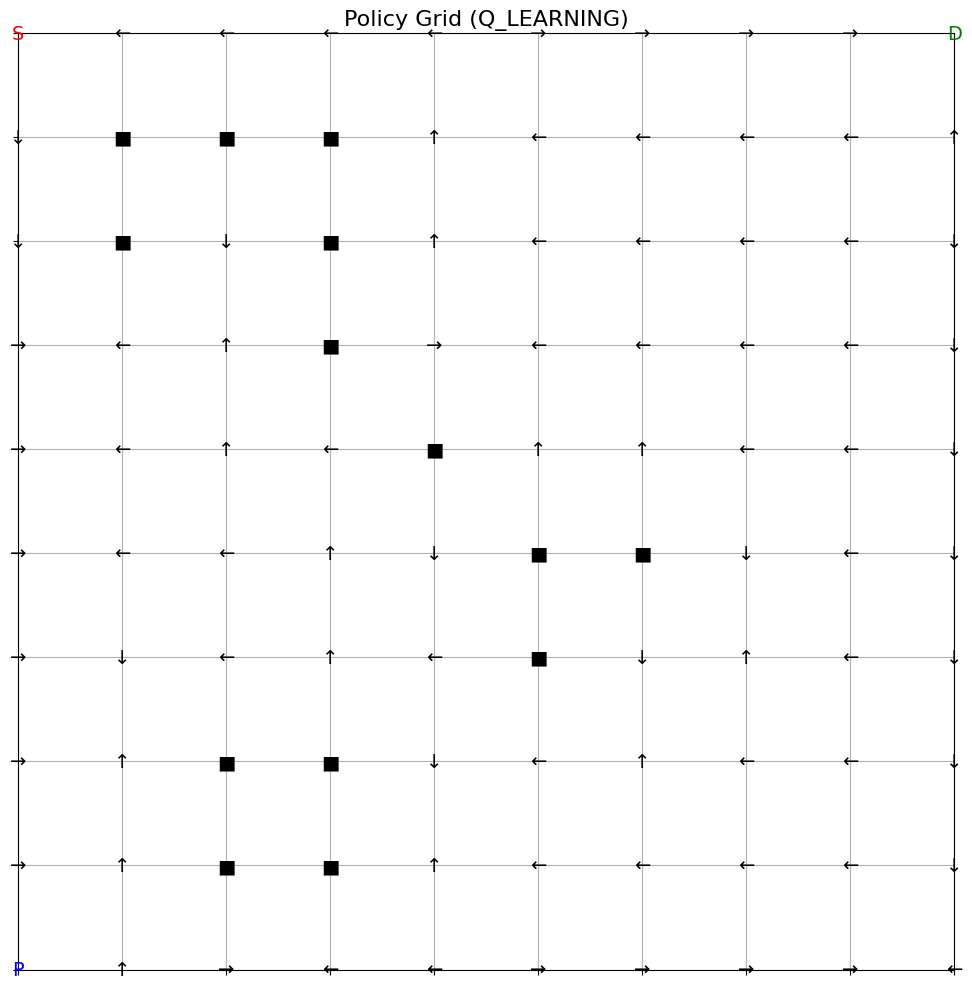

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.99      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


### Exploration rate (0.0, 0.5)

🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-10.46617457 -10.         -10.46617457 -10.        ]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [-10.         -10.         -10.46617457 -10.46617457]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-10.46617457 -10.46617457 -10.         -10.        ]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [-10.         -10.         -10.46617457 -10.46617457]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-10.46617457 -10.46617457 -10.         -10.        ]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-10.46617457 -10.46617457 -10.         -10.        ]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'E', 'E'), 0): [-10.46617457 -10.         -10.         -10.        ]
(('E', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [-10.         -10.         -10.46617457 -10.        ]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-10.46617457 -10. 

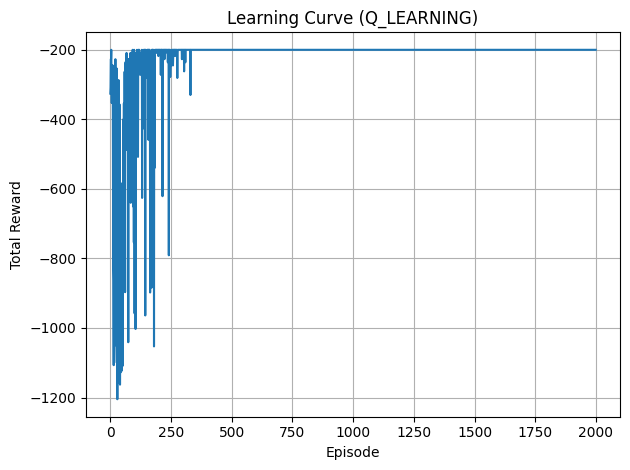

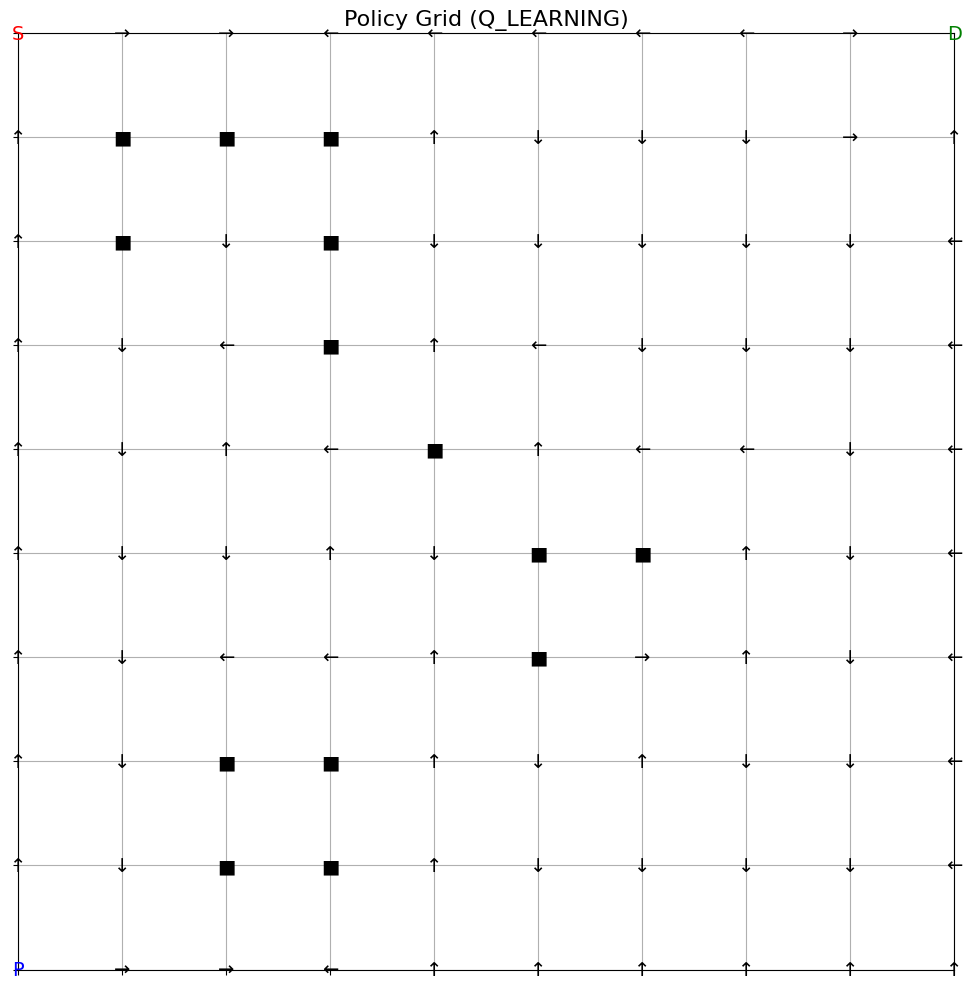

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.0    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-19. -10. -19. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-19.         -18.99999999 -10.         -10.        ]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [-10. -10. -19. -19.]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [-10. -10. -19. -19.]
(('W', 'E', 'O', 'W', 'E', 'E', 'W', 'E', 'E'), 0): [-10.         -10.         -18.99999999 -10.        ]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-19. -19. -10. -10.]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-18.99999999 -18.99999999 -10.         -10.        ]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'E', 'E'), 0): [-18.99999999 -10.         -10.         -10.        ]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-18.99999999 -10.         -10.         -10.        ]
(('E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-10. -10. -10. -10.]
(('E', 'E', 'E', 'E

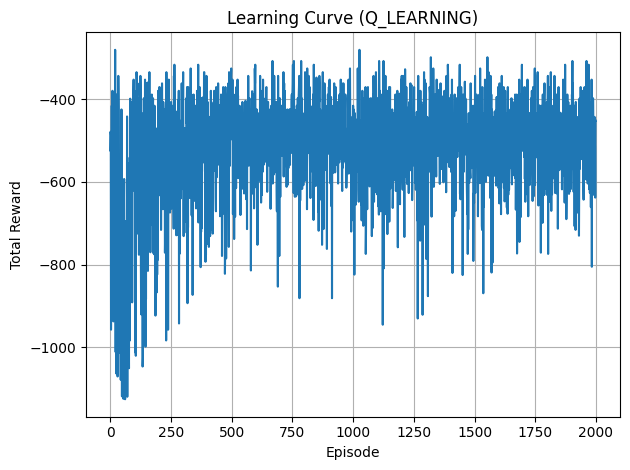

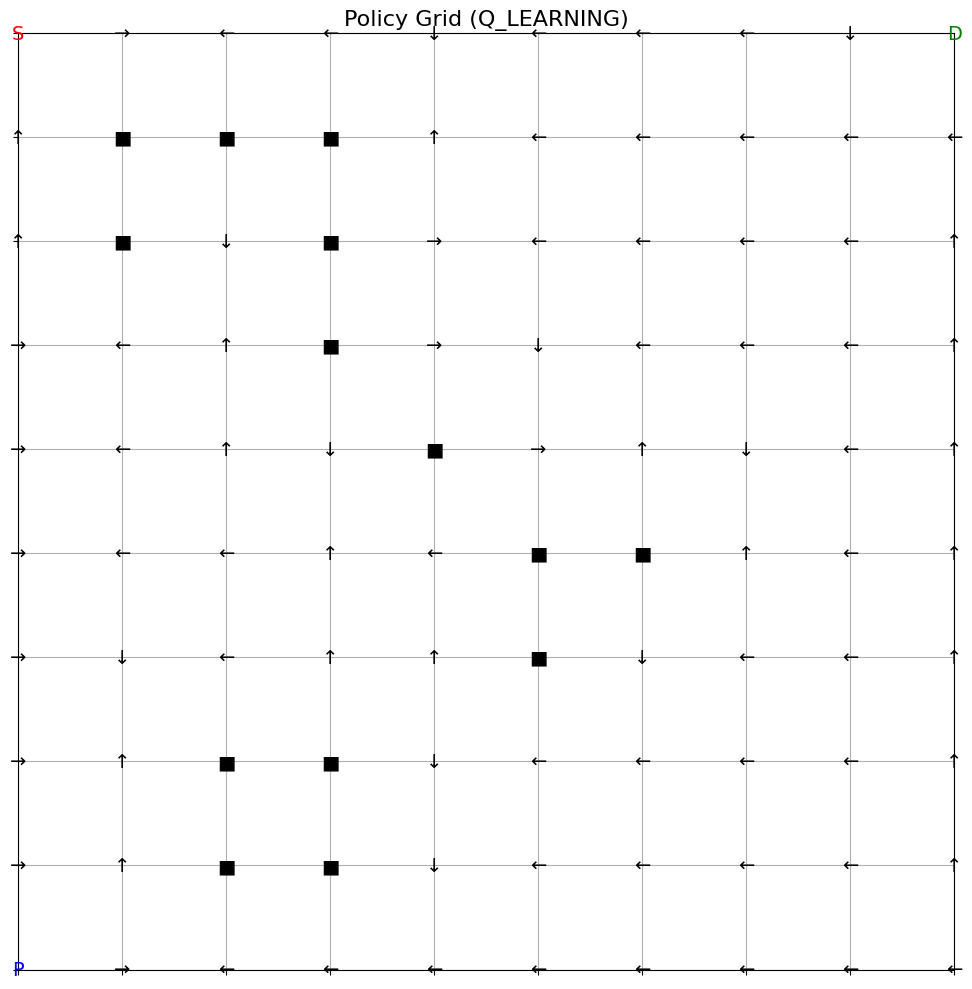

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.5    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


### Number of Episodes (500, 5000)

🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-18.9522833   -9.98469733 -18.94751439  -9.98461463]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [ -9.98442653  -9.98450666 -18.92010741 -18.95005053]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-18.94236626 -18.91145635  -9.98428781  -9.98416775]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-18.77970065 -18.895211    -9.9837716   -9.98355458]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [ -9.9842739   -9.98409983 -18.86492469 -18.92125805]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-18.92276265 -18.91410422  -9.98293005  -9.98299648]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'E', 'E'), 0): [-18.94103213  -9.98227562  -9.9822535   -9.98254884]
(('E', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [ -9.98153659  -9.98164665 -18.95880519  -9.98228053]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-18.97945062  -9.9

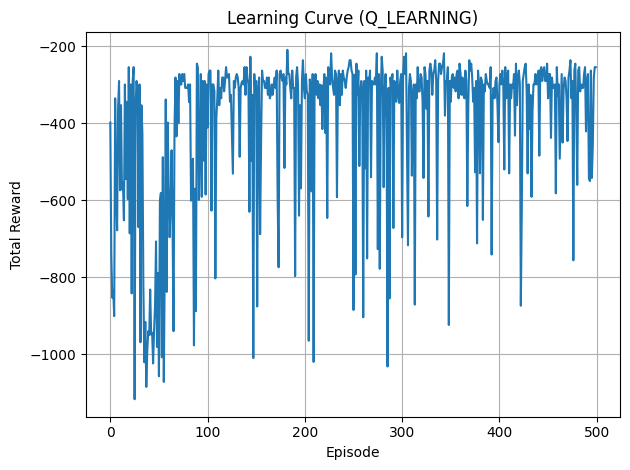

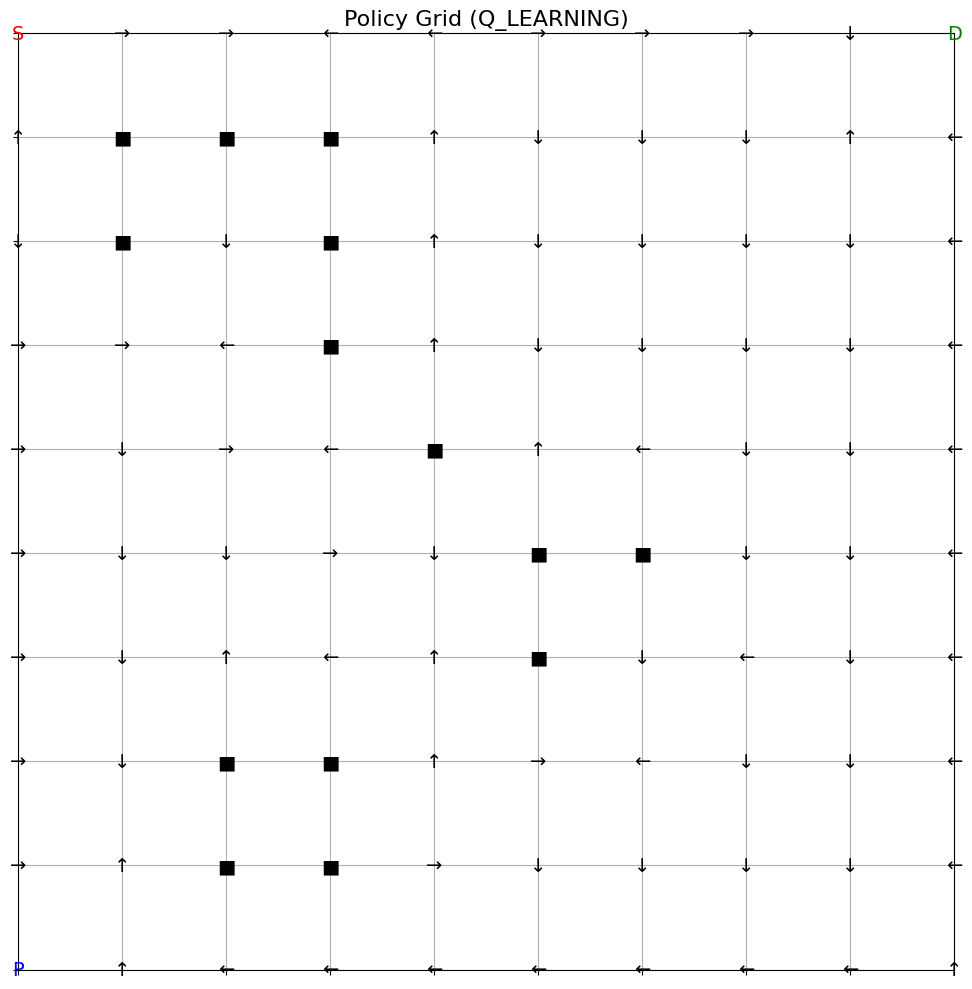

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 500  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-19. -10. -19. -10.]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [-10. -10. -19. -19.]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-19. -19. -10. -10.]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [-10. -10. -19. -19.]
(('W', 'E', 'O', 'W', 'E', 'E', 'W', 'E', 'E'), 0): [-10. -10. -19. -10.]
(('W', 'E', 'E', 'W', 'E', 'E', 'W', 'E', 'E'), 0): [-10. -10. -19. -10.]
(('E', 'O', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-19. -10. -10. -10.]
(('O', 'E', 'O', 'E', 'E', 'O', 'E', 'E', 'E'), 0): [-10. -10. -10. -19.]
(('O', 'O', 'O', 'O', 'E', 'O', 'E', 'E', 'O'), 0): [-19.         -10.         -18.99999998 -18.99999999]
(('E', 'E', 'O', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-10. -10. -10. -10.]
(('E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-10. -10. -10. -10.]


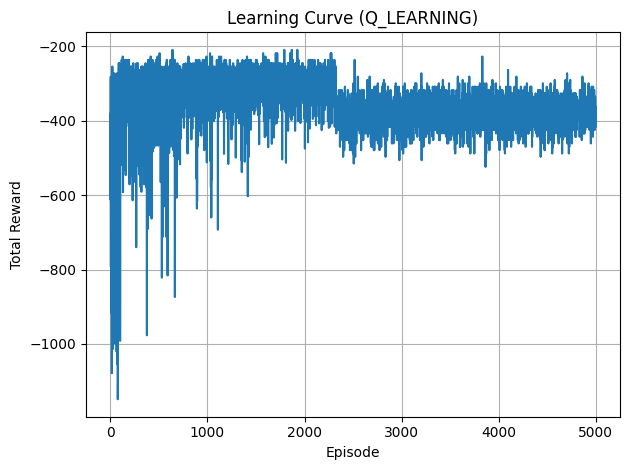

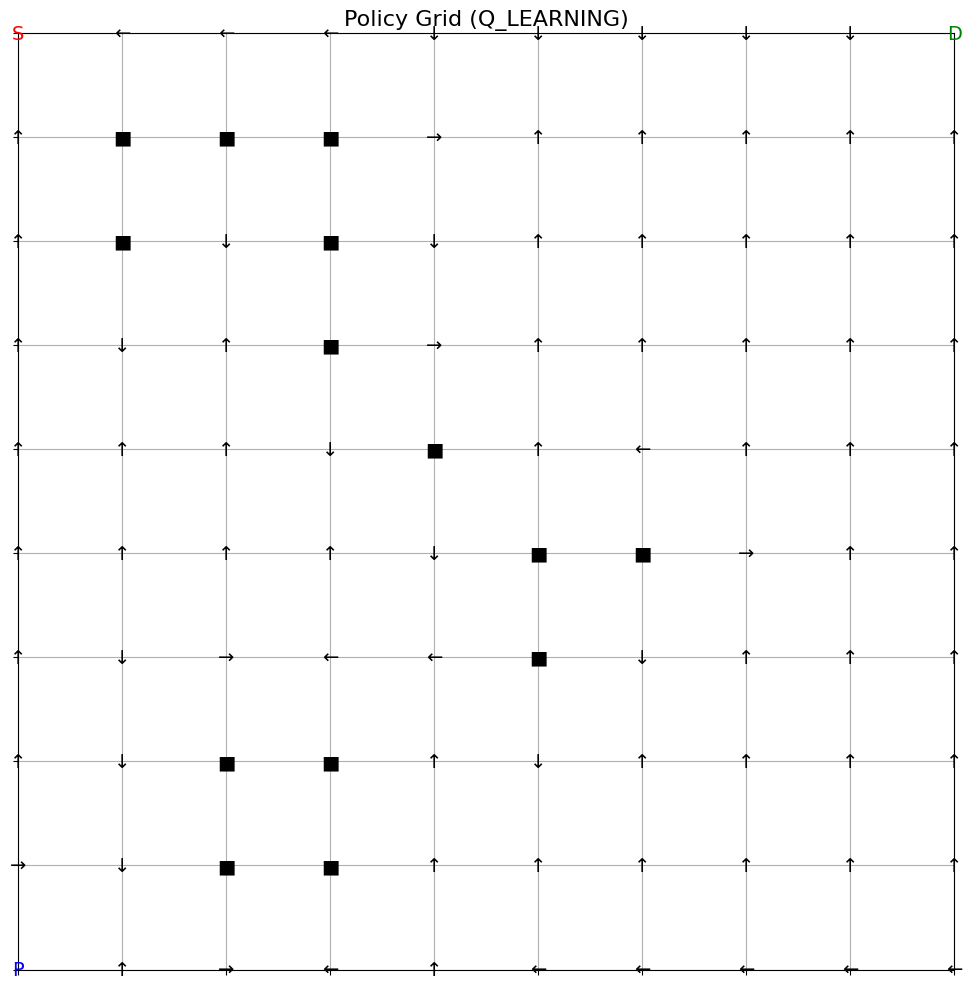

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 5000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparing Q-Learning and SARSA

🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-23.16525991 -12.22909542 -23.32004305 -15.27071373]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [-14.55437922 -11.77619285 -22.5902518  -21.42983956]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [-12.95512408 -11.66193189 -20.83120883 -21.24387862]
(('W', 'E', 'O', 'W', 'E', 'E', 'W', 'E', 'E'), 0): [-12.62153903 -11.09758072 -21.00916207 -12.1371221 ]
(('W', 'E', 'E', 'W', 'E', 'E', 'W', 'E', 'E'), 0): [-11.77194348 -13.1058731  -20.57444431 -10.9459879 ]
(('E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'O'), 0): [-10.83885574 -11.50301084 -11.44395731 -11.06346186]
(('E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-11.27856267 -11.34696201 -11.65664633 -10.87400345]
(('E', 'E', 'O', 'E', 'E', 'E', 'E', 'E', 'E'), 0): [-11.65906391 -11.06292506 -10.89023924 -11.55534244]
(('E', 'O', 'E', 'E', 'E', 'O', 'E', 'E', 'E'), 0): [-19.85618902 -11.0

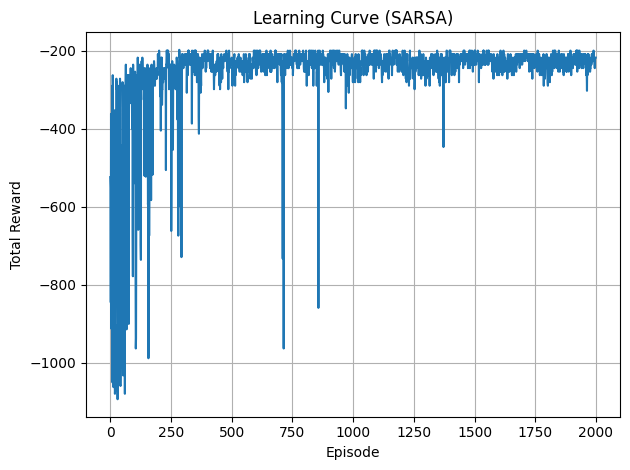

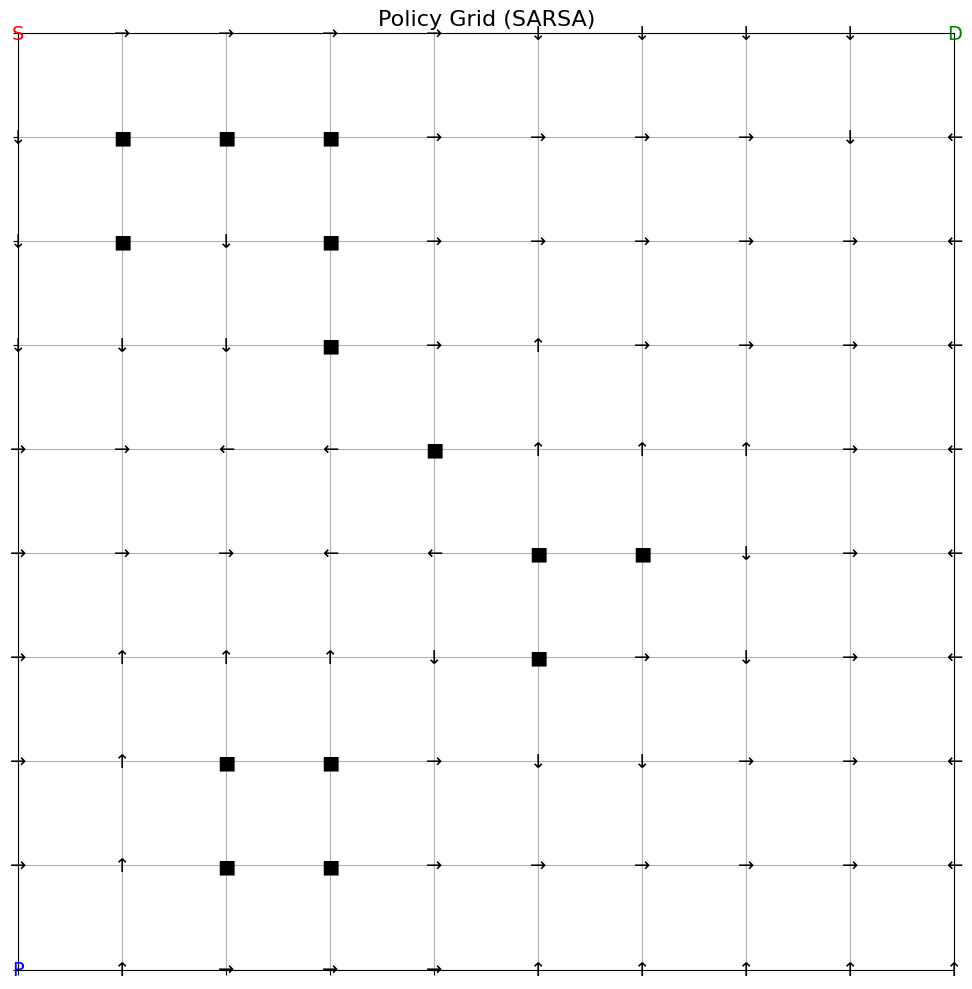

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()



🔁 Running Q_LEARNING for 5 runs...

🔁 Running SARSA for 5 runs...


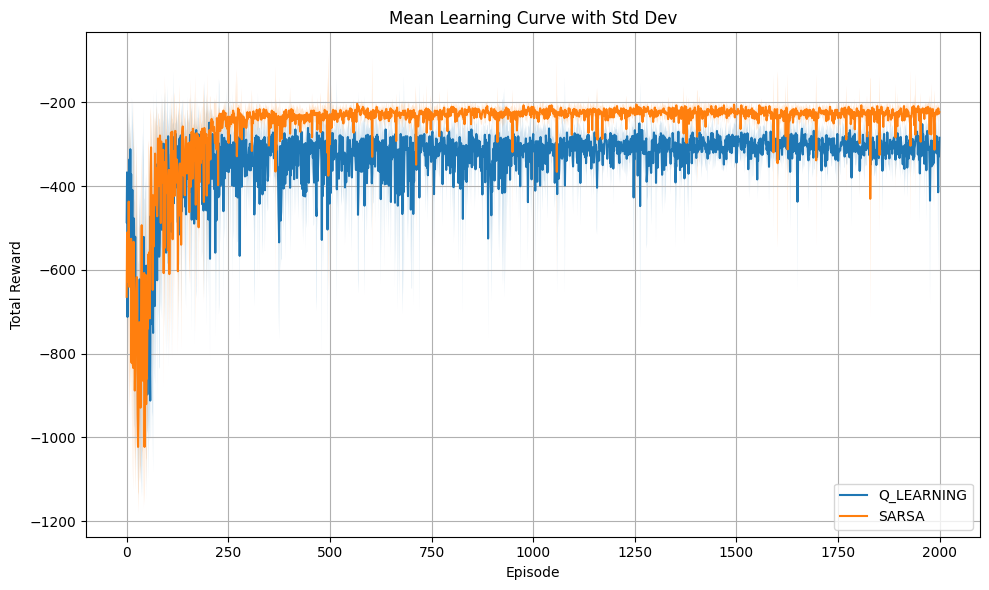


📊 Final Mean Reward (last 100 episodes):
Q_LEARNING: -311.19 ± 6.47
SARSA: -228.14 ± 6.06


In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.


# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')
    return tuple(view)

def take_action(x, y, carrying, action):
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# ⚖️ Comparison Setup
# ========================================
num_runs = 5
last_n = 100
algorithms = ['q_learning', 'sarsa']
results = {algo: [] for algo in algorithms}

for algorithm in algorithms:
    print(f"\n🔁 Running {algorithm.upper()} for {num_runs} runs...")

    for run in range(num_runs):
        random.seed(run)
        np.random.seed(run)

        Q_table = {}
        rewards_per_episode = []

        def get_Q(local_view, carrying):
            key = (local_view, carrying)
            if key not in Q_table:
                Q_table[key] = np.zeros(len(ACTIONS))
            return Q_table[key]

        for episode in range(episodes):
            x, y = START_LOCATION
            carrying = 0
            total_reward = 0

            local_view = get_local_view(x, y)
            Q_values = get_Q(local_view, carrying)
            action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
            action = ACTIONS[action_idx]

            for _ in range(200):
                new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
                next_local_view = get_local_view(new_x, new_y)
                next_Q = get_Q(next_local_view, new_carrying)

                if algorithm == 'q_learning':
                    Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
                    next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
                elif algorithm == 'sarsa':
                    next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
                    Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

                x, y, carrying = new_x, new_y, new_carrying
                local_view = next_local_view
                Q_values = next_Q
                action_idx = next_action_idx
                action = ACTIONS[action_idx]
                total_reward += reward

            rewards_per_episode.append(total_reward)

        results[algorithm].append(rewards_per_episode)

# Convert to numpy
for algo in algorithms:
    results[algo] = np.array(results[algo])

# Plot Learning Curves
plt.figure(figsize=(10, 6))
for algo in algorithms:
    mean = results[algo].mean(axis=0)
    std = results[algo].std(axis=0)
    plt.plot(mean, label=f"{algo.upper()}")
    plt.fill_between(range(episodes), mean - std, mean + std, alpha=0.2)
plt.title("Mean Learning Curve with Std Dev")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Performance
print("\n📊 Final Mean Reward (last 100 episodes):")
for algo in algorithms:
    final_rewards = results[algo][:, -last_n:].mean(axis=1)
    print(f"{algo.upper()}: {final_rewards.mean():.2f} ± {final_rewards.std():.2f}")


## Env Modifications

🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-18.9999999   -9.99999998 -18.99999993  -9.99999998]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [ -9.99999998  -9.99999998 -18.99999995 -18.99999984]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [ -9.99999998  -9.99999997 -18.99999988 -18.99999984]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-18.99999992 -18.99999987  -9.99999998  -9.99999998]
(('W', 'E', 'O', 'W', 'E', 'E', 'W', 'E', 'E'), 0): [ -9.99999997  -9.99999997 -18.99999996  -9.99999997]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-18.99999989 -18.99999992  -9.99999998  -9.99999998]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-18.9999999  -18.99999988  -9.99999998  -9.99999998]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'E', 'E'), 0): [-18.99999996  -9.99999998  -9.99999998  -9.99999998]
(('E', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [ -9.99999997  -9.9

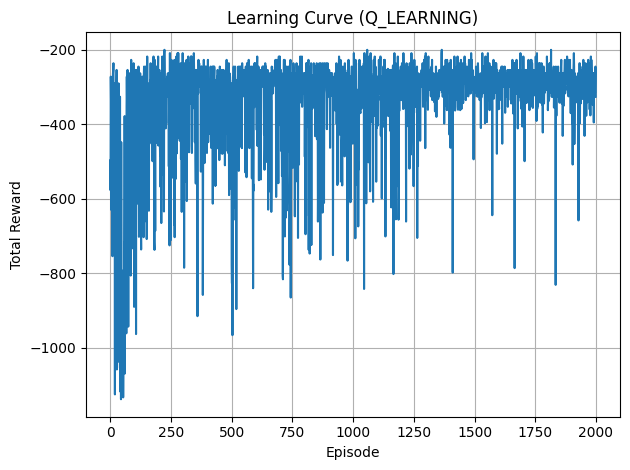

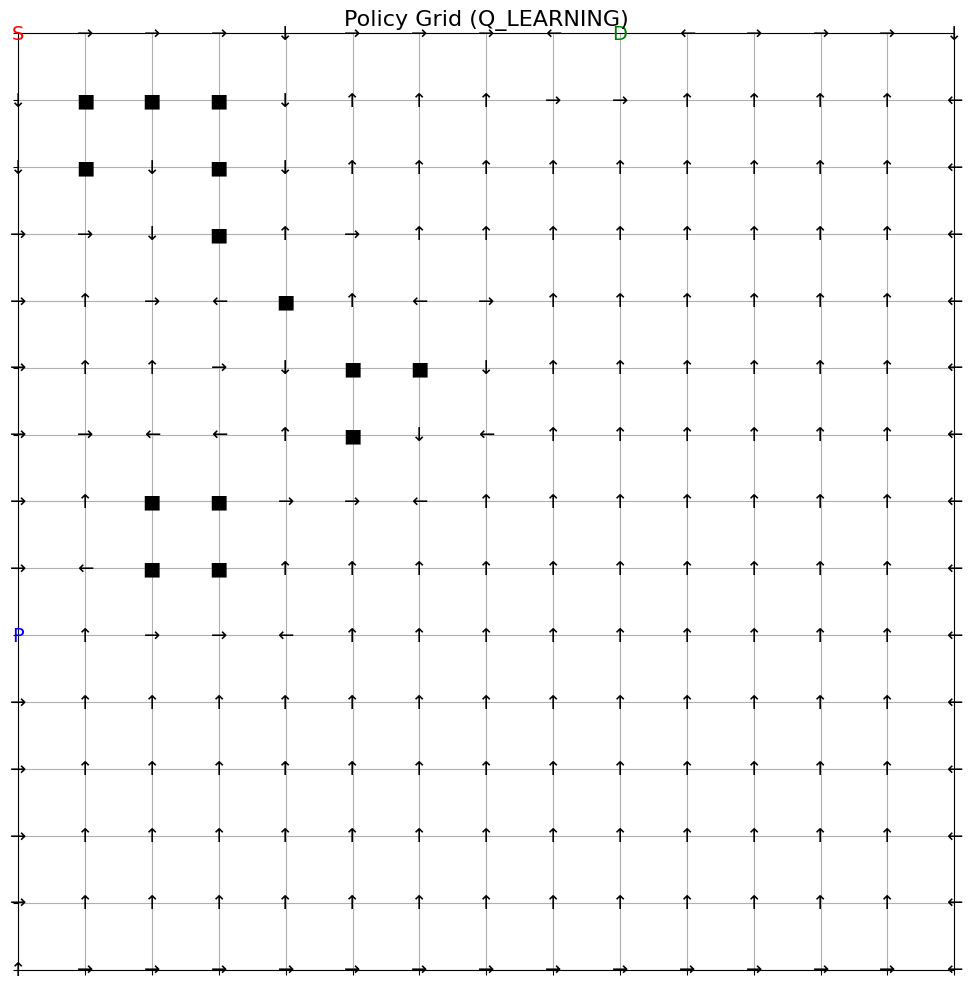

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 15
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


🔸 Initial Q-table (should be empty):

✅ Final Q-table sample (first 10 entries):
(('W', 'W', 'W', 'W', 'E', 'E', 'W', 'E', 'O'), 0): [-18.99999988  -9.99999995 -18.99999989  -9.99999995]
(('W', 'E', 'E', 'W', 'E', 'O', 'W', 'E', 'O'), 0): [ -9.99999995  -9.99999995 -18.99999978 -18.99999937]
(('W', 'W', 'W', 'E', 'E', 'E', 'E', 'O', 'O'), 0): [-18.99999969 -18.99999979  -9.99999995  -9.99999995]
(('W', 'E', 'O', 'W', 'E', 'O', 'W', 'E', 'E'), 0): [ -9.99999995  -9.99999995 -18.99999977 -18.99999971]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'O'), 0): [-18.99999987 -18.9999998   -9.99999995  -9.99999995]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'O', 'E'), 0): [-18.99999967 -18.99999982  -9.99999995  -9.99999995]
(('W', 'W', 'W', 'E', 'E', 'E', 'O', 'E', 'E'), 0): [-18.99999986  -9.99999994  -9.99999994  -9.99999994]
(('E', 'E', 'E', 'O', 'E', 'E', 'O', 'E', 'E'), 0): [ -9.99999994  -9.99999994 -18.99999989  -9.99999994]
(('W', 'E', 'O', 'W', 'E', 'E', 'W', 'E', 'E'), 0): [ -9.99999994  -9.9

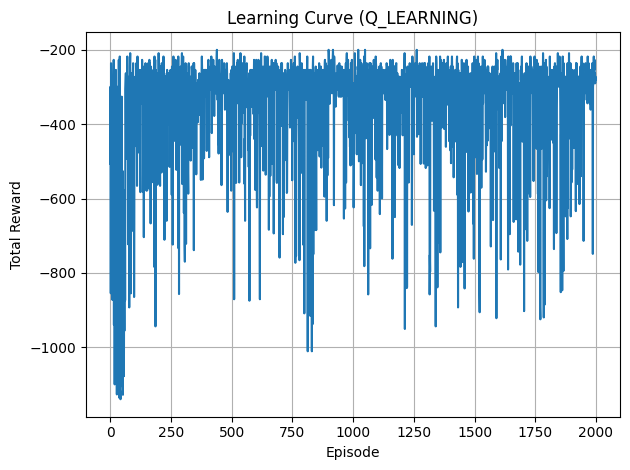

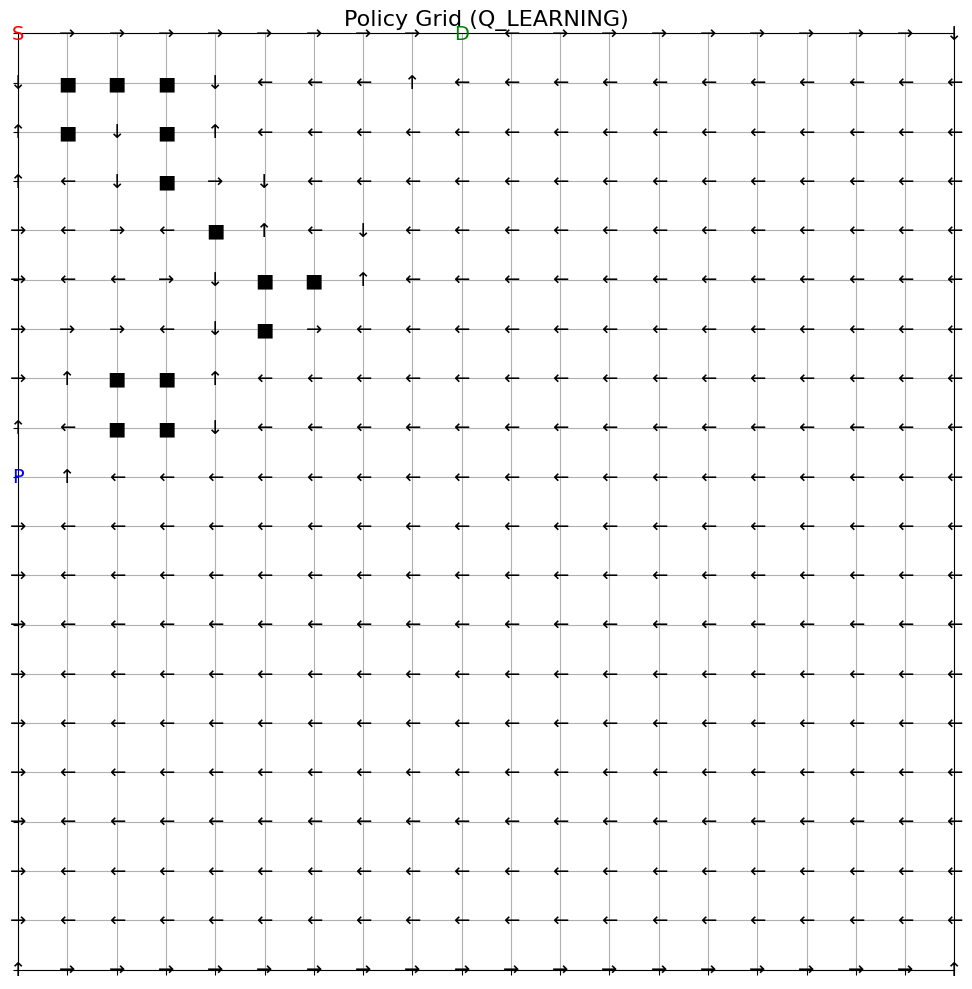

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
# This warehouse environment is **partially observable**:
#   - The robot cannot observe its absolute (x, y) position.
#   - It only sees a 3x3 grid around its current location (local view).
#
# Normally, Q-learning assumes full observability (i.e., Q(s, a) for known states).
# But here, we adapt Q-learning to work in partial observability by:
#   - Defining state as (local_view, carrying), where local_view is a tuple of 9 values.
#   - The robot learns a Q-value for each observed 3x3 configuration + carrying state.
#
# 🔍 Justification:
#   - Q-learning can still converge in partially observable environments if:
#       - There are repeated observable configurations.
#       - The robot's actions can meaningfully affect long-term rewards.
#   - This models real-world robots or drones that only see part of the world at each step.
#   - SARSA is also available here for on-policy (safer) learning under the same state representation.

# ========================================
# 🧠 Algorithm Selection:
# ========================================
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🧱 Environment Setup
# ========================================
GRID_SIZE = 20
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# ⚙️ Learning Parameters
# ========================================
alpha = 0.1      # Learning rate: how quickly to update Q-values
gamma = 0.9      # Discount factor: how much to value future rewards
epsilon = 0.2    # Exploration rate: chance to explore random actions
episodes = 2000  # Total number of training episodes

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    """Return 3x3 view centered at (x, y) as a tuple of 9 characters."""
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

Q_table = {}

def get_Q(local_view, carrying):
    """Return Q-values for a given state or initialize if unseen."""
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    """Simulate moving in the grid and returning next state and reward."""
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Training Loop
# ========================================
print("🔸 Initial Q-table (should be empty):")
for i, key in enumerate(Q_table.keys()):
    print(f"{key}: {Q_table[key]}")
    if i >= 10:
        break

rewards_per_episode = []

for episode in range(episodes):
    x, y = START_LOCATION
    carrying = 0
    total_reward = 0

    local_view = get_local_view(x, y)
    Q_values = get_Q(local_view, carrying)
    action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
    action = ACTIONS[action_idx]

    for _ in range(200):
        new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
        next_local_view = get_local_view(new_x, new_y)
        next_Q = get_Q(next_local_view, new_carrying)

        if algorithm == 'q_learning':
            # Q-learning: off-policy
            Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
        elif algorithm == 'sarsa':
            # SARSA: on-policy
            next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

        x, y, carrying = new_x, new_y, new_carrying
        local_view = next_local_view
        Q_values = next_Q
        action_idx = next_action_idx
        action = ACTIONS[action_idx]
        total_reward += reward

    rewards_per_episode.append(total_reward)

# ========================================
# 🧾 Final Q-table (sample)
# ========================================
print("\n✅ Final Q-table sample (first 10 entries):")
for i, (key, value) in enumerate(Q_table.items()):
    print(f"{key}: {value}")
    if i >= 10:
        break

# ========================================
# 📈 Learning Curve
# ========================================
plt.plot(rewards_per_episode)
plt.title(f"Learning Curve ({algorithm.upper()})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 🗺️ Policy Grid Visualization
# ========================================
policy_grid = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pos = (i, j)
        if pos in OBSTACLES:
            policy_grid[i, j] = '■'
        elif pos == PICKUP_LOCATION:
            policy_grid[i, j] = 'P'
        elif pos == DROPOFF_LOCATION:
            policy_grid[i, j] = 'D'
        elif pos == START_LOCATION:
            policy_grid[i, j] = 'S'
        else:
            view = get_local_view(i, j)
            Q_vals = get_Q(view, 0)
            best_action = ACTIONS[np.argmax(Q_vals)]
            policy_grid[i, j] = ARROWS[best_action]

# Plot grid with color-coded cells and directions
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f"Policy Grid ({algorithm.upper()})", fontsize=16)
ax.set_xticks(np.arange(GRID_SIZE))
ax.set_yticks(np.arange(GRID_SIZE))
ax.set_xticklabels([])
ax.set_yticklabels([])
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        text = policy_grid[i, j]
        color = (
            'red' if (i, j) == START_LOCATION else
            'blue' if (i, j) == PICKUP_LOCATION else
            'green' if (i, j) == DROPOFF_LOCATION else
            'black'
        )
        ax.text(j, i, text, va='center', ha='center', fontsize=14, color=color)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


## Params Exploration Extra Method

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
import os

# ========================================
# 🤖 PROBLEM SETTING & PARTIAL OBSERVABILITY
# ========================================
GRID_SIZE = 10
OBSTACLES = {
    (1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3), (4, 4),
    (5, 5), (5, 6), (6, 5), (7, 2), (8, 2), (7, 3), (8, 3)
}
PICKUP_LOCATION = (9, 0)
DROPOFF_LOCATION = (0, 9)
START_LOCATION = (0, 0)

ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_MAP = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
ARROWS = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}

# ========================================
# 🧱 Helper Functions
# ========================================
def is_valid(pos):
    x, y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in OBSTACLES

def get_local_view(x, y):
    view = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) in OBSTACLES:
                    view.append('O')
                elif (nx, ny) == PICKUP_LOCATION:
                    view.append('P')
                elif (nx, ny) == DROPOFF_LOCATION:
                    view.append('D')
                else:
                    view.append('E')
            else:
                view.append('W')  # Wall or out-of-bounds
    return tuple(view)

def get_Q(Q_table, local_view, carrying):
    key = (local_view, carrying)
    if key not in Q_table:
        Q_table[key] = np.zeros(len(ACTIONS))
    return Q_table[key]

def take_action(x, y, carrying, action):
    dx, dy = ACTION_MAP[action]
    new_x, new_y = x + dx, y + dy
    if not is_valid((new_x, new_y)):
        return x, y, -10, carrying  # Invalid move penalty
    reward = -1
    if not carrying and (new_x, new_y) == PICKUP_LOCATION:
        carrying = 1
        reward = 10
    elif carrying and (new_x, new_y) == DROPOFF_LOCATION:
        carrying = 0
        reward = 20
    elif carrying and (new_x, new_y) != DROPOFF_LOCATION:
        reward = -5
    return new_x, new_y, reward, carrying

# ========================================
# 🔁 Experiment Parameters
# ========================================
param_grid = {
    'alpha': [0.01, 0.5],
    'gamma': [0.5, 0.99],
    'epsilon': [0.0, 0.5],
    'episodes': [500, 5000]
}
algorithm = 'q_learning'  # or 'sarsa'

# ========================================
# 🔄 Run Experiments
# ========================================
os.makedirs("sensitivity_results", exist_ok=True)

experiment_id = 0
for alpha, gamma, epsilon, episodes in itertools.product(
    param_grid['alpha'],
    param_grid['gamma'],
    param_grid['epsilon'],
    param_grid['episodes']
):
    experiment_id += 1
    print(f"\n▶️ Running Experiment {experiment_id} | α={alpha}, γ={gamma}, ε={epsilon}, episodes={episodes}")

    Q_table = {}
    rewards_per_episode = []

    for episode in range(episodes):
        x, y = START_LOCATION
        carrying = 0
        total_reward = 0

        local_view = get_local_view(x, y)
        Q_values = get_Q(Q_table, local_view, carrying)
        action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(Q_values)
        action = ACTIONS[action_idx]

        for _ in range(200):
            new_x, new_y, reward, new_carrying = take_action(x, y, carrying, action)
            next_local_view = get_local_view(new_x, new_y)
            next_Q = get_Q(Q_table, next_local_view, new_carrying)

            if algorithm == 'q_learning':
                Q_values[action_idx] += alpha * (reward + gamma * np.max(next_Q) - Q_values[action_idx])
                next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
            elif algorithm == 'sarsa':
                next_action_idx = random.randint(0, 3) if random.uniform(0, 1) < epsilon else np.argmax(next_Q)
                Q_values[action_idx] += alpha * (reward + gamma * next_Q[next_action_idx] - Q_values[action_idx])

            x, y, carrying = new_x, new_y, new_carrying
            local_view = next_local_view
            Q_values = next_Q
            action_idx = next_action_idx
            action = ACTIONS[action_idx]
            total_reward += reward

        rewards_per_episode.append(total_reward)

    # Save learning curve
    plt.plot(rewards_per_episode)
    plt.title(f"Learning Curve (α={alpha}, γ={gamma}, ε={epsilon}, ep={episodes})")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.tight_layout()
    fname = f"sensitivity_results/curve_{experiment_id}_a{alpha}_g{gamma}_e{epsilon}_ep{episodes}.png"
    plt.savefig(fname)
    plt.close()
    print(f"📈 Saved learning curve to: {fname}")

    # Save Q-table sample
    sample_q_path = f"sensitivity_results/qtable_{experiment_id}_a{alpha}_g{gamma}_e{epsilon}_ep{episodes}.txt"
    with open(sample_q_path, "w") as f:
        for i, (key, value) in enumerate(Q_table.items()):
            f.write(f"{key}: {value.tolist()}\n")
            if i >= 10:
                break
    print(f"💾 Saved Q-table sample to: {sample_q_path}")

print("\n✅ All experiments completed!")



▶️ Running Experiment 1 | α=0.01, γ=0.5, ε=0.0, episodes=500
📈 Saved learning curve to: sensitivity_results/curve_1_a0.01_g0.5_e0.0_ep500.png
💾 Saved Q-table sample to: sensitivity_results/qtable_1_a0.01_g0.5_e0.0_ep500.txt

▶️ Running Experiment 2 | α=0.01, γ=0.5, ε=0.0, episodes=5000
📈 Saved learning curve to: sensitivity_results/curve_2_a0.01_g0.5_e0.0_ep5000.png
💾 Saved Q-table sample to: sensitivity_results/qtable_2_a0.01_g0.5_e0.0_ep5000.txt

▶️ Running Experiment 3 | α=0.01, γ=0.5, ε=0.5, episodes=500
📈 Saved learning curve to: sensitivity_results/curve_3_a0.01_g0.5_e0.5_ep500.png
💾 Saved Q-table sample to: sensitivity_results/qtable_3_a0.01_g0.5_e0.5_ep500.txt

▶️ Running Experiment 4 | α=0.01, γ=0.5, ε=0.5, episodes=5000
📈 Saved learning curve to: sensitivity_results/curve_4_a0.01_g0.5_e0.5_ep5000.png
💾 Saved Q-table sample to: sensitivity_results/qtable_4_a0.01_g0.5_e0.5_ep5000.txt

▶️ Running Experiment 5 | α=0.01, γ=0.99, ε=0.0, episodes=500
📈 Saved learning curve to: sens

In [15]:
!zip -r /content/sensitivity_results.zip /content/sensitivity_results
from google.colab import files
files.download('/content/sensitivity_results.zip')

  adding: content/sensitivity_results/ (stored 0%)
  adding: content/sensitivity_results/qtable_16_a0.5_g0.99_e0.5_ep5000.txt (deflated 80%)
  adding: content/sensitivity_results/qtable_2_a0.01_g0.5_e0.0_ep5000.txt (deflated 74%)
  adding: content/sensitivity_results/curve_1_a0.01_g0.5_e0.0_ep500.png (deflated 3%)
  adding: content/sensitivity_results/qtable_3_a0.01_g0.5_e0.5_ep500.txt (deflated 63%)
  adding: content/sensitivity_results/curve_3_a0.01_g0.5_e0.5_ep500.png (deflated 2%)
  adding: content/sensitivity_results/qtable_11_a0.5_g0.5_e0.5_ep500.txt (deflated 65%)
  adding: content/sensitivity_results/curve_15_a0.5_g0.99_e0.5_ep500.png (deflated 2%)
  adding: content/sensitivity_results/qtable_14_a0.5_g0.99_e0.0_ep5000.txt (deflated 88%)
  adding: content/sensitivity_results/curve_13_a0.5_g0.99_e0.0_ep500.png (deflated 4%)
  adding: content/sensitivity_results/curve_12_a0.5_g0.5_e0.5_ep5000.png (deflated 4%)
  adding: content/sensitivity_results/qtable_7_a0.01_g0.99_e0.5_ep500.t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>